In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import yaml

import astropy.units as u
import astropy.io.fits as pyfits

import mastquery.utils
import mastquery.jwst

from grizli import utils
import msaexp.slit_combine
import msaexp.spectrum
import msaexp
from msaexp import pipeline

import glob

print('msaexp version: ', msaexp.__version__)


os.chdir('/lustre/JDAP/home/jdap04/temp/') ### take things out of git for now

msaexp version:  0.8.5


# Finding objects of interest

Before getting into various steps of the NIRSpec data reduction first lets look at how we can plan some science with data in the archive. 

Imagine that you are intersted in studying the formation of massive galaxies in the early Universe. In our current cosmological models galaxies grow via hierachichal merging. To test the formation and evolution of galaxies we can try to find the most massive quiescent galaxies that are formed in the first ~2 billion years of the Universe. 

You do a literature search and find the first massive quiescent galaxies that was spectrscopically confirmed at z>3. The galaxy is presented in Glazebrook+2017 https://ui.adsabs.harvard.edu/abs/2017Natur.544...71G/abstract 

This was done before JWST was operational. The data is from the MOSFIRE instrument in the Keck Telescopes and only covers the K band. You want to see whether someone has obtained a JWST spectrum of this galaxy and use it for your science. 


**Exercise:**
Go to MAST website https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html and find if there are any observations.


## Checking data through grizli

You can also use the services provided by DJA https://dawn-cph.github.io/dja/index.html to perfom this serach.

In [9]:

# Find the program, source_id based on a particular position
ra, dec = 150.06149, 2.3787093 ## 20115

slits_url = f"https://grizli-cutout.herokuapp.com/nirspec_slits?coord={ra},{dec}"
slits = utils.read_catalog(slits_url, format='csv')

slits['program','msametfl','source_id','grating','footprint'][slits['is_source'] == 'True']

program,msametfl,source_id,grating,footprint
int64,str25,int64,str5,str89
3567,jw03567004001_01_msa.fits,54459,G235M,"((150.061438,2.378670),(150.061411,2.378730),(150.061540,2.378784),(150.061566,2.378724))"
3567,jw03567004001_01_msa.fits,54459,G235M,"((150.061435,2.378670),(150.061409,2.378730),(150.061537,2.378784),(150.061564,2.378724))"
3567,jw03567004001_01_msa.fits,54459,G235M,"((150.061441,2.378670),(150.061414,2.378730),(150.061543,2.378784),(150.061569,2.378724))"
2565,jw02565007001_01_msa.fits,20115,PRISM,"((150.061519,2.378754),(150.061539,2.378693),(150.061411,2.378649),(150.061390,2.378711))"
2565,jw02565007001_01_msa.fits,20115,PRISM,"((150.061523,2.378754),(150.061543,2.378693),(150.061414,2.378649),(150.061394,2.378710))"
2565,jw02565007001_01_msa.fits,20115,PRISM,"((150.061526,2.378754),(150.061547,2.378693),(150.061418,2.378649),(150.061398,2.378710))"


OK so there are multiple observations of the source by 2 different programs

Let us now first check the footprint of the data.

(-0.5, 239.5, 239.5, -0.5)

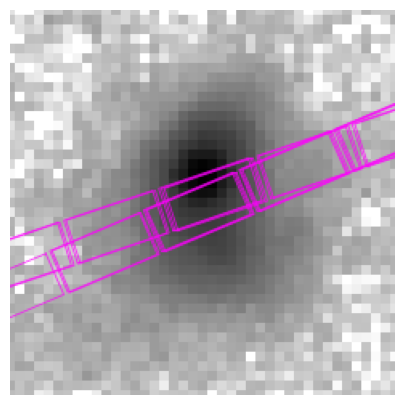

In [10]:
import PIL
import urllib

# Cutout figure
cutout_url = f"https://grizli-cutout.herokuapp.com/thumb?size=1&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord={ra},{dec}&nirspec=True&dpi_scale=6&nrs_source=magenta&nrs_other=magenta&nrs_lw=0.5&nrs_alpha=0.8"

img = np.array(PIL.Image.open(urllib.request.urlopen(cutout_url)))

fig, ax = plt.subplots(1,1,figsize=(5,5))
_ = ax.imshow(img[::-1,:,:])
ax.axis('off')

So the object is observed but we need to look into details a bit more.  

**Exercise:**


1. Go to DJA website and find the galaxy
2. Figure out which program has public data
3. Use the APT and ALADIN to visualize the galaxy and objects. Specifically look for where the trace of the primary object of interest falls, any contamination probelms, and what the exposure time specifications are.



After this steps you should have a good general understanding on navigating various platforms to learn about the data. i.e. observing modes,  exposure times, settings used by the observers etc. 

Check if there are any public data availble for this galaxy.

Yes! They are publicly available!

Now we are ready to start looking at the spectral data.

# Accessing data from MAST

First lets download the 1D spectrum of the galaxy to see how it looks. You can compare your result at the end of the day with what the default pipleine has given. 

In [11]:
PROGRAM='02565'
OBSERVTN='007'
FILTER = 'clear'
GRATING='prism'
SOURCEID = '20115'#, '15089'


In [12]:
mast_file = f'jw{PROGRAM}-o{OBSERVTN}_s{SOURCEID}_nirspec_{FILTER}-{GRATING}_x1d.fits'.lower()
mast_url = 'https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:JWST/product/' + mast_file

mast = utils.read_catalog(mast_url)

## Plot the spectrum 

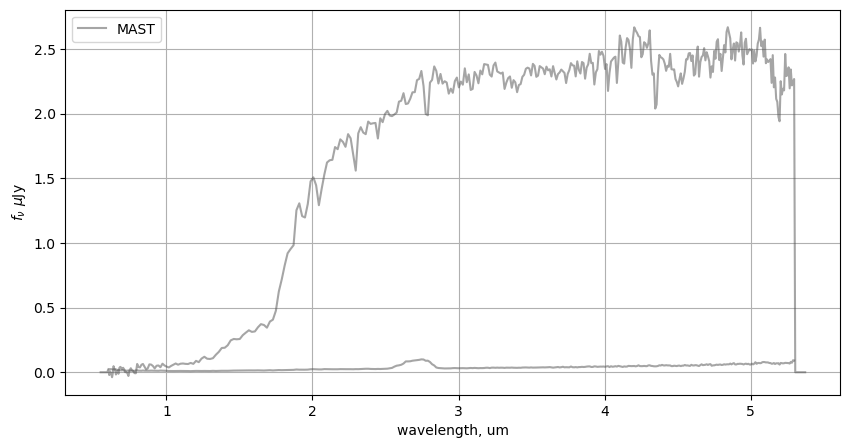

In [13]:
fig, ax = plt.subplots(1,1,figsize=(10,5))


pl = ax.plot(mast['WAVELENGTH'], mast['FLUX'].to('microJansky'), label='MAST', color='0.3', alpha=0.5)
ax.plot(mast['WAVELENGTH'], mast['FLUX_ERROR'].to('microJansky'), color=pl[0].get_color(), alpha=0.5)

ax.legend()

ax.set_xlabel('wavelength, um')
ax.set_ylabel(r'$f_\nu$ $\mu$Jy')
ax.grid()

# Download Stage 1 data products

We shall do the reductions ourselves first to obtain a better quality spectrum. For that, we will start with Stage 2 data products from MAST. 


We will skip downloading *uncal.fits files (Stage 1 data products) because they are very big. You can find them in /lustre/JDAP/jdap_data/nirspec_mos/data. 



In [18]:
prog =  2565
detectors = ['nrs1', 'nrs2']
gratings = ['prism']
mask_query = mastquery.jwst.make_query_filter('visit_id', values=['02565007001'])


# Query NIRSpec data for a program name
masks = pipeline.query_program(prog,
    download=True,
    detectors=detectors,
    gratings=gratings,
    product='rate', #'uncal'
    extra_filters=mask_query, 
)

files = glob.glob(f'jw0{prog}*rate.fits')

print(files)

2024-06-25 11:12:45,550 - stpipe - WARNING - No files with extensions ['s2d'] found.
2024-06-25 11:12:45,551 - stpipe - WARNING - Available extensions are []


Nothing found.
[]


In [ ]:
prog = 1386 # 2565
detectors = ['nrs1', 'nrs2']
gratings = ['prism']
mask_query = mastquery.jwst.make_query_filter('visit_id', values=['02565007001'])


# Query NIRSpec data for a program name
masks = pipeline.query_program(prog,
    download=True,
    detectors=detectors,
    gratings=gratings,
    product='rate', #'uncal'
    extra_filters=mask_query, 
)

files = glob.glob(f'jw0{prog}*rate.fits')

print(files)